## An Example of Behavior Analysis

In this example, we will show examples of using trained DisAE or DBE models to analyze unlabeled behavioral videos.

In [1]:
import os
import pickle
from glob2 import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.analysis import generate_labels, get_states, generate_mapping, gather_motifs, dlc_regression, convert_date

### Evaluate the Continuous Pose Embeddings

In this section, we evaluate the continuous pose embeddings of the video frames. We will show that these embeddings contain meaningful information about the behavioral dynamics of our animals. To be able to do that, we formulate a linear regression task from the pose embeddings to the DLC trajectories. First, we load the embeddings learned by the DisAE model to jupyter notebook, as well as the DLC trajectories. If you haven't generate the embeddings of videos, please follow the evaluation instruction on the github main page. 

In [2]:
exp = 'disae-example'
mod = 'train'
with open('./outputs/{}/{}_latents.pkl'.format(exp, mod), 'rb') as f:
    latents = pickle.load(f)
with open('./outputs/{}/{}_trials.pkl'.format(exp, mod), 'rb') as f:
    trials = pickle.load(f)
with open('./outputs/{}/{}_DLCs.pkl'.format(exp, mod), 'rb') as f:
    DLCs = pickle.load(f)
    dlc_trials, markers, dlcs = DLCs['trials'], DLCs['markers'], DLCs['dlcs']

We then fit a simple linear regression model for each session: the inputs are the pose embeddings and the targets are the DLC coordinates of some predefined markers (specifically we mark the 5 fingers and the center of Mouse's right paw for the Hand-Reach dataset). The reason that we fit separate models for different sessions is that the DLC trajectories contain context information while the pose embeddings supposedly don't. The R2 scores of the linear regression models show that the DLC trajectories can be predicted from pose embeddings, thus demonstrate that pose embeddings contain meaningful behavioral information.

In [3]:
all_sessions = list(set([t.rsplit('/', 2)[1] for t in trials]))
all_score = {}
for session in all_sessions:
    _, score = dlc_regression(latents, trials, dlcs, dlc_trials, markers, session)
    all_score[session] = score

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

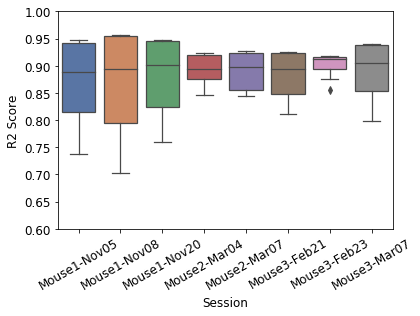

In [4]:
import seaborn as sns
all_score_df = pd.DataFrame.from_dict(all_score)
all_score_df.columns = ['-'.join([n.split('-', 1)[0], convert_date(n.split('-', 1)[1])]) for n in all_score_df.columns]
all_score_df = all_score_df[['C9-Nov05', 'C9-Nov08', 'C9-Nov20', 'OT4-Mar04', 'OT4-Mar07', 'PT39-Feb21', 'PT39-Feb23', 'PT39-Mar07']]
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=all_score_df[all_score_df['C9-Nov05']>0.5], palette="deep", linewidth=1.25)
plt.xlabel('Session', fontsize=12)
plt.ylabel('R2 Score', fontsize=12)
plt.ylim(0.6, 1)
plt.xticks(np.arange(8), ['Mouse1-Nov05','Mouse1-Nov08','Mouse1-Nov20','Mouse2-Mar04','Mouse2-Mar07','Mouse3-Feb21','Mouse3-Feb23','Mouse3-Mar07'], rotation=30, fontsize=12)
plt.yticks(fontsize=12)

We then visually compare the true DLC trajectories and the trajectories generated by linear regression from the learned latent embeddings. The true DLC trajectories and the generated trajectories during a lift action is shown here.

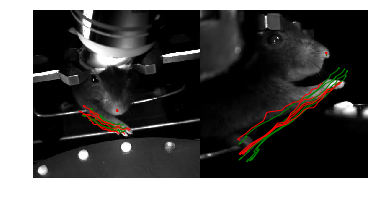

In [13]:
idx = [t.rsplit('/', 1)[1] for t in trials if 'PT39-2021-03-07' in t].index('304')
dlc_reg, _ = dlc_regression(latents, trials, dlcs, dlc_trials, markers, 'PT39-2021-03-07')
y = dlcs[dlc_trials.index('PT39_3_7_21_304'), 750:1150]
img = cv2.imread('/data2/changhao/Dataset/Behavioral-Videos/Videos/PT39-2021-03-07/304/img_0910.jpg')
clip_range = range(130, 160)
for i in range(12):
    plt.plot(dlc_reg[i][idx, clip_range, 0].astype(int), dlc_reg[i][idx, clip_range, 1].astype(int), color="green", linewidth=1)
    plt.plot(y[clip_range, 3*i].astype(int), y[clip_range, 3*i+1].astype(int), color="red", linewidth=1)
plt.axis('off')
plt.imshow(img)
plt.show()

### Evaluate the Discrete Motif Segmentation

Now, we move from DisAE model to DBE model to evaluate the discrete motif segmentation. First of all, we load the continuous pose embeddings and the estimated states (the discrete latent variables in DBE) of the behavioral videos generated by the DBE model. 

In [127]:
exp = 'dbe-example'
mod = 'train'
with open('./outputs/{}/{}_latents.pkl'.format(exp, mod), 'rb') as f:
    latents = pickle.load(f)
with open('./outputs/{}/{}_states.pkl'.format(exp, mod), 'rb') as f:
    states = pickle.load(f)
with open('./outputs/{}/{}_trials.pkl'.format(exp, mod), 'rb') as f:
    trials = pickle.load(f)
with open('./outputs/{}/{}_contents_all.pkl'.format(exp, mod), 'rb') as f:
    contents = pickle.load(f)

Let's briefly look at the state estimation of the training videos. Different colors indicate different behavioral states the model learns. Videos from different sessions share the same state space which indicates that the model disentangles the behavioral dynamics from the no-behavioral context information. Note that the model is trained in a fully supervised manner, meaning that we don't use any maunal labeling to train the model even with these training videos.

Text(0,0.5,'Session')

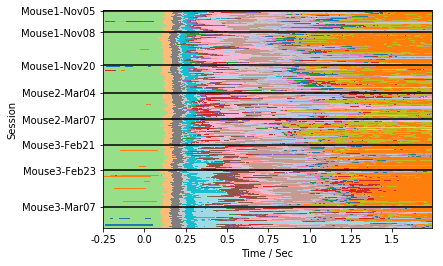

In [11]:
ys = []
trial_sessions = [t.rsplit('/', 2)[1] for t in trials]
trial_sessions = ['-'.join([n.split('-', 1)[0], convert_date(n.split('-', 1)[1])]) for n in trial_sessions]
animal_names = ['Mouse1-Nov05','Mouse1-Nov08','Mouse1-Nov20','Mouse2-Mar04','Mouse2-Mar07','Mouse3-Feb21','Mouse3-Feb23','Mouse3-Mar07']
for session in set(trial_sessions):
    ys.append((trial_sessions).index(session))
plt.figure(figsize=(8, 4))
plt.imshow(states.argmax(-1), cmap='tab20')
plt.hlines(ys, xmin=0, xmax=398)
plt.xticks(range(0, 399, 50), np.arange(-0.25, 2, 0.25))
plt.yticks(sorted(ys), animal_names)
plt.xlabel('Time / Sec')
plt.ylabel('Session')

Then we load the unseen test videos for evaluation.

In [13]:
mod = 'test'
with open('./outputs/{}/{}_latents.pkl'.format(exp, mod), 'rb') as f:
    latents = pickle.load(f)
with open('./outputs/{}/{}_states.pkl'.format(exp, mod), 'rb') as f:
    states = pickle.load(f)
with open('./outputs/{}/{}_trials.pkl'.format(exp, mod), 'rb') as f:
    trials = pickle.load(f)
with open('./outputs/{}/{}_contents_all.pkl'.format(exp, mod), 'rb') as f:
    contents = pickle.load(f)

To evaluate the quality of motif segmentation, we will also need some ground truth labeling of the behaviors. We ask human experts to manually label 8 behavioral states that we are interested in, including 'Perch', 'Lift', 'Reach', 'Grab', 'To_Mouth', 'At_Mouth', 'Back_To_Perch'. Note that human experts only label those frames with clear correspondences and not all the frames in evaluation videos are labeled. Due to the setting of our behavioral neuroscience experiments, we use the 400 frames which contain most meaningful actions instead of the whole videos for the evaluation.

In [18]:
with open('./manual_labels.pkl', 'rb') as f:
    gt = pickle.load(f)
classes = ['Perch', 'Lift', 'Reach', 'Grab', 'Sup', 'At_mouth', 'Back_to_perch']
labels = generate_labels(gt, classes)[:, 751:1150]

We use 3 different metrics to evaluate the quality of the motif segmentation. Apart from the accuracy, we also choose ARI and NMI which are common metrics for clustering evaluation. We use sklearn to calculate these metrics. Note that to make our evaluation more meaningful, we use the middle 200 frames which is a more balanced subset of states to calculate the metrics.

In [19]:
lrange = range(100,300)
gt_states = get_states(states, trials, gt)
mapped_states, mapping = generate_mapping(gt_states, labels, n_states=30)
pred, tar = mapped_states[:, lrange][labels[:, lrange]>0], labels[:, lrange][labels[:, lrange]>0]
acc = (pred==tar).mean()

In [12]:
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(tar, pred)
nmi = normalized_mutual_info_score(tar, pred)
print('acc: {} / ari: {} / nmi: {}'.format(acc, ari, nmi))

acc: 0.7964059196617336 / ari: 0.6493305862796303 / nmi: 0.6687796210434326


Now we plot the confusion matrix of the model prediction. The high diagonal values indicate that the predictions have good quality.

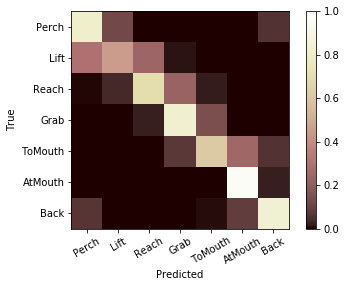

In [12]:
from sklearn.metrics import confusion_matrix
classes = ['Perch', 'Lift', 'Reach', 'Grab', 'ToMouth', 'AtMouth', 'Back']
plt.tight_layout()
plt.imshow(confusion_matrix(tar, pred, normalize='true'), cmap='pink')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(tar_labels)), classes, rotation=30)
plt.yticks(range(len(tar_labels)), classes)
plt.colorbar()
plt.clim([0, 1])

To have a more intuitive understanding of the state estimations, we segment the videos into motifs based on the estimated states and then visualize the results. For every segmented motif which is essentially a continuous sequence of frames, we plot the begining frame in the blue channel and the ending frame in the red channel. 

Text(0.5,0.98,'Lift')

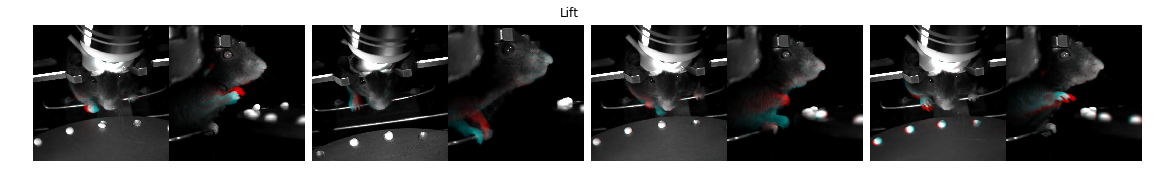

In [70]:
motifs_27, info = gather_motifs(trials, states, 27)
plt.figure(figsize=(20, 2.5))
plt.tight_layout()
for i, k in enumerate(np.random.randint(0, len(motifs_25), 4)):
    plt.subplot(1,4,i+1)
    plt.imshow(motifs_25[k]/255., cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.1)
plt.suptitle('Lift')

Text(0.5,0.98,'Reach')

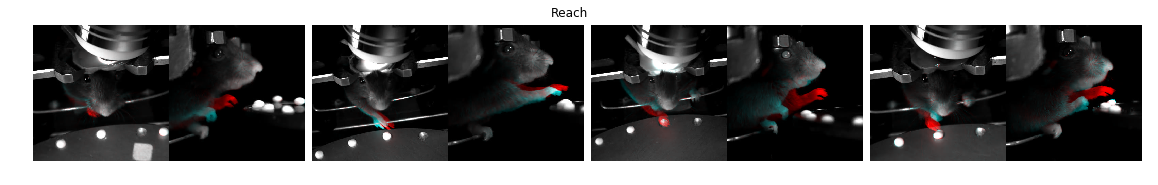

In [44]:
motifs_12, info = gather_motifs(trials, states, 12)
plt.figure(figsize=(20, 2.5))
plt.tight_layout()
for i, k in enumerate(np.random.randint(0, len(motifs_12), 4)):
    plt.subplot(1,4,i+1)
    plt.imshow(motifs_12[k]/255., cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.1)
plt.suptitle('Reach')

263it [00:41,  6.40it/s]


Text(0.5,0.98,'Grab')

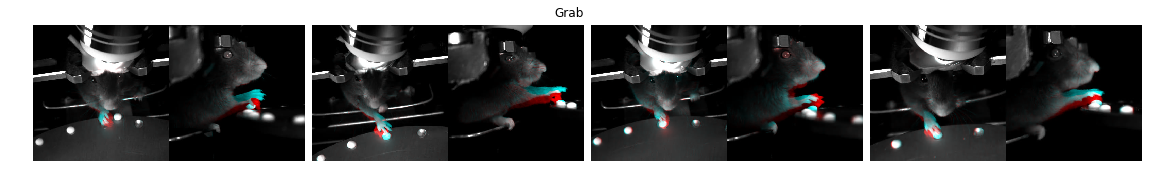

In [73]:
motifs_11, info = gather_motifs(trials, states, 11)
plt.figure(figsize=(20, 2.5))
plt.tight_layout()
for i, k in enumerate(np.random.randint(0, len(motifs_11), 4)):
    plt.subplot(1,4,i+1)
    plt.imshow(motifs_11[k]/255., cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.1)
plt.suptitle('Grab')